<a href="https://colab.research.google.com/github/sim-so/weekly-presentation-season1/blob/main/08_abstractive_summarization/08_AbstractiveSummarization_PracticeCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 생성 요약 : Abstrative Summarization

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install datasets

# Summarization with HuggingFace pipeline (ENG)

## Dataset : CNN dailymail

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


In [ ]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


## Text Summarization Pipelines
- reference: https://huggingface.co/docs/transformers/main_classes/pipelines

In [ ]:
sample_text = dataset["train"][1]["article"][:2000]
summaries = {}

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### Summarization Baseline

In [ ]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries["baseline"] = three_sentence_summary(sample_text)

In [ ]:
summaries   # 3문장만 잘려야 하는 게 아닌가??

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'}

In [ ]:
from transformers import pipeline
from transformers import set_seed

set_seed(42)

### GPT-2

In [ ]:
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"])
)

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
summaries["gpt2"]

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."\nHere, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court.\nMost often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies."\nHe says the arrests often result from confrontations with police.\nMentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely t

In [ ]:
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :])
)

In [ ]:
summaries["gpt2"]

'A mental health ward is housed in a single room below a courtroom called what many have been calling an "outpost," since an inmate on the outpost floor would go on trial in the nearby courthouse.\nWhen we arrived, it was a hot, clear day.\nThere were a number of jailers around to help take photos of the area.\nThe guards, Leifman'

### T5

In [ ]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### BART

In [ ]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### PEGASUS

In [ ]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"]

In [ ]:
summaries["pegasus"]

'Mentally ill inmates in Miami are housed on the "forgotten floor"<n>The ninth floor is where they\'re held until they\'re ready to appear in court .<n>Most often, they face drug charges or charges of assaulting an officer .<n>They end up on the ninth floor severely mentally disturbed .'

In [ ]:
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [ ]:
summaries["pegasus"]

'Mentally ill inmates in Miami are housed on the "forgotten floor"<n>The ninth floor is where they\'re held until they\'re ready to appear in court.\nMost often, they face drug charges or charges of assaulting an officer.\nThey end up on the ninth floor severely mentally disturbed .'

## Comparing Different Summaries

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

PEGASUS
Mentally ill inmates in Miami are housed on the "forgotten floor"<n>The ninth floor is where they're held until they're ready to appear in court.
Most often, they face drug charges or charges of assaulting an office

## Measuring the Quality of Generated Text

### BLEU

In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 13.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

<ipython-input-25-eacc06f6d0e4>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [ ]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [ ]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROUGE

In [ ]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=8535e0e72763ab37f3642e6104962109eb3e683b77c394d6aede22a1df740580
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge_score


In [ ]:
rouge_metric = load_metric("rouge")

In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
pegasus,0.323232,0.206186,0.282828,0.323232
gpt2,0.252252,0.036697,0.180180,0.216216
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842


## Evaluating PEGASUS on the CNN/DailyMail Dataset

In [ ]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i+batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                           padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                              clean_up_tokenization_spaces=True)
                            for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 125/125 [23:22<00:00, 11.22s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434759,0.216742,0.312271,0.374631


## Training a Summarization Model

In [ ]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.0/379.0 KB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 KB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.7/139.7 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 KB 13.3 MB/s eta 0:00:00


In [ ]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary: ")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary: 
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


## Evaluating PEGASUS on SAMSUM

In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [ ]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])


100%|██████████| 103/103 [17:20<00:00, 10.10s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


## Fine-Tuning PEGASUS

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


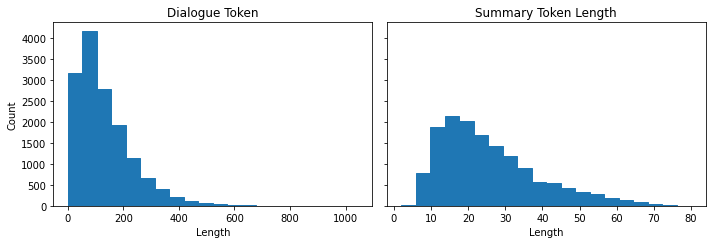

In [ ]:
import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)

axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")

plt.tight_layout()
plt.show()

In [ ]:
def convert_examples_to_features(example_batch):
    input_encoding = tokenizer(example_batch["dialogue"], max_length=128, truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
    return {"input_ids": input_encoding["input_ids"],
            "attention_mask": input_encoding["attention_mask"],
            "labels": target_encodings["input_ids"]}
    
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

  0%|          | 0/15 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
text = ["PAD", "Transformers", "are", "awesome", "for", "text", "summarization"]
rows = []
for i in range(len(text)-1):
    rows.append({"step": i+1, "decoder_input": text[:i+1], "label": text[i+1]})
pd.DataFrame(rows).set_index("step")

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    output_dir="pegasus-samsum", 
    num_train_epochs=1, warmup_steps=500, weight_decay=0.01, 
    logging_steps=10, evaluation_strategy="steps", eval_steps=500, 
    save_steps=1e6, gradient_accumulation_steps=16,
    push_to_hub=True,
)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
trainer = Trainer(model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

Cloning https://huggingface.co/sim-so/pegasus-samsum into local empty directory.


In [ ]:
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary"
)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: id, dialogue, summary. If id, dialogue, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 16
  Total optimization steps = 115
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__c

Step,Training Loss,Validation Loss


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

  6%|▋         | 26/410 [01:02<11:29,  1.80s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "max_length": 128,
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

  7%|▋         | 27/410 [01:04<11:11,  1.75s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "max_length": 128,
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

  7%|▋         | 28/410 [01:06<11:18,  1.78s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "m

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.349153,0.140882,0.273728,0.273898


In [ ]:
trainer.push_to_hub("Training complete!")

Saving model checkpoint to pegasus-samsum
Configuration saved in pegasus-samsum/config.json
Configuration saved in pegasus-samsum/generation_config.json
Model weights saved in pegasus-samsum/pytorch_model.bin
tokenizer config file saved in pegasus-samsum/tokenizer_config.json
Special tokens file saved in pegasus-samsum/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/2.13G [00:00<?, ?B/s]

Upload file runs/Feb14_14-10-24_98a56abe91bf/events.out.tfevents.1676383973.98a56abe91bf.590.0: 100%|#########…

Upload file training_args.bin: 100%|##########| 3.37k/3.37k [00:00<?, ?B/s]

Upload file runs/Feb14_14-10-24_98a56abe91bf/1676383973.3241897/events.out.tfevents.1676383973.98a56abe91bf.59…

Upload file spiece.model:   2%|1         | 32.0k/1.82M [00:00<?, ?B/s]

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/sim-so/pegasus-samsum
   6acb6e6..451e003  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/sim-so/pegasus-samsum
   6acb6e6..451e003  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'samsum', 'type': 'samsum', 'config': 'samsum', 'split': 'validation', 'args': 'samsum'}}
To https://huggingface.co/sim-so/pegasus-samsum
   451e003..fce9c2e  main -> main

   451e003..fce9c2e  main -> main



'https://huggingface.co/sim-so/pegasus-samsum/commit/451e0039de8baf0854a9e1cac6144c2675c1db82'

### Generating Dialogue Summaries

In [ ]:
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 129}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="sim-so/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called her last time they were at the park together. Hannah would rather she text him. Amanda Bye bye.


In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom and Lewis are writing a book about Hugging Face's transformers. Leandro is in on the idea. Thom and Lewis are already in on the idea.
